In [1]:
import sys
sys.path.append("../src")

In [2]:
import torch
from model import DiffusionModule
from sampler import ImageSampler
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch import nn

In [10]:
import importlib
import model
importlib.reload(model)
from model import DiffusionModule

In [11]:
def show_image(x, axis=plt):
    axis.imshow(torch.clip(x.transpose(0, 1).transpose(1, 2)*0.5 + 0.5, 0, 1))

In [12]:
model = DiffusionModule.load_from_checkpoint("../checkpoints/2vogwh9g.ckpt")

In [13]:
x = ImageSampler(model, max_iter=100).sample()

Generating image samples: 100%|██████████| 100/100 [00:10<00:00,  9.40it/s]


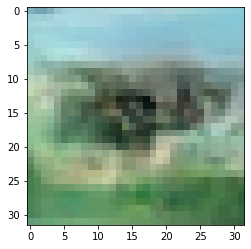

In [14]:
show_image(x[0])
plt.show()

In [205]:
torch.linspace(0, 20, 11).round().int()

tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20], dtype=torch.int32)

# Known Working

In [ ]:
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(shape[0], *((1,) * (len(shape) - 1)))
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()

class Generator(nn.Module):
    def __init__(self, model):
        super().__init__()
        
        self.denoise_fn = model
        self.num_timesteps = model.max_t
        
        beta_1, beta_t = 1e-4, 1e-2

        betas = torch.tensor(np.linspace(beta_1, beta_t, model.max_t), dtype=torch.float)
        
        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        self.register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        self.register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        self.register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        self.register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        self.register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        self.register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))
        
    def q_mean_variance(self, x_start, t):
        mean = extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = extract(1. - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool):
        x_recon = self.predict_start_from_noise(x, t=t, noise=self.denoise_fn(x, t))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, repeat_noise=False):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance = self.p_mean_variance(x=x, t=t, clip_denoised=clip_denoised)
        noise = noise_like(x.shape, device, repeat_noise)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, shape):
        device = self.betas.device

        b = shape[0]
        img = torch.randn(shape, device=device)

        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long))
        return img

    @torch.no_grad()
    def sample(self, batch_size = 16, image_size=32, channels=3):
        return self.p_sample_loop((batch_size, channels, image_size, image_size))